In [1]:
%matplotlib inline

In this section, we will learn to extract signals in ROIs from fMRI data and compute a connectome with them.

# Extracting signal on a parcellation

##### We are going to load the Harvard-Oxford atlas, in it's 'max-prob' version, ie the non probabilistic version:

In [12]:
from nilearn import datasets, plotting
hv_ds = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
atlas_img, labels = hv_ds['maps'], hv_ds['labels']

In [22]:
import nibabel as nib
import numpy as np
atlas_nifti = nib.load(atlas_img)
atlas_data = atlas_nifti.get_data()
len(np.unique(atlas_data))

49

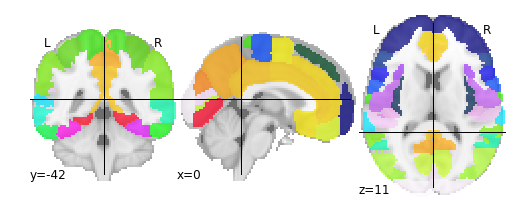

In [13]:

plotting.plot_roi(atlas_img)

To extract signals on this atlas, we create an "Masker" object, that can transform niftis in time-series using a set of labels (the non-probabilistic atlas).

In [23]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_img)

# Now get the ADHD data
data = datasets.fetch_adhd(n_subjects=1)

# And apply the masker to the functional data
time_series = masker.fit_transform(data.func[0])

In [25]:
time_series.shape

(176, 48)

In [24]:
time_series.mean()

9347.7308391460647

This take a little time. To avoid recomputing steps later, we can use the 'memory' argument of the masker. Also, to follow what's happening, we can use the 'verbose' argument.

Now our 'time_series' should be a numpy array of shape: (time, n_labels)

In [6]:
time_series.shape

(152, 48)

We can plot these time-series using matplotlib:

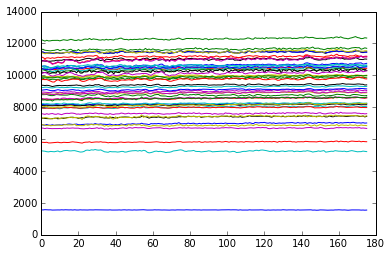

In [26]:
from matplotlib import pyplot as plt
plot = plt.plot(time_series)

We can immediatly see that there an ROI-specific offset that is of little interest to us. Let's standardize time-series during extraction (center and norm them), with the "standardize" option of the masker:

[NiftiLabelsMasker.fit_transform] loading data from /usr/local/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/Users/admin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'high_pass': None,
  'labels_img': '/usr/local/fsl/data/atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, memory_level=1, verbose=5, memory=Memory(cachedir='/tmp/nilearn_course/joblib'))
[NiftiLabelsMasker.transform_single_imgs] Loading data from /Users/admin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiLabelsMasker

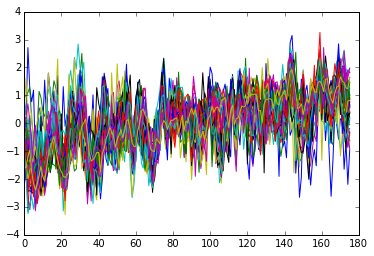

In [27]:
masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True,
                           memory='/tmp/nilearn_course', verbose=5)

time_series = masker.fit_transform(data.func[0])
plot = plt.plot(time_series)

We can now use numpy to plot a correlation matrix, which will be the correlation of the signals across ROIs

In [28]:
import numpy as np
correlation = np.corrcoef(time_series.T)

In [29]:
correlation

array([[ 1.        ,  0.74585185,  0.87202997, ...,  0.649928  ,
         0.72274874,  0.76287504],
       [ 0.74585185,  1.        ,  0.82690623, ...,  0.73627977,
         0.65317367,  0.77749149],
       [ 0.87202997,  0.82690623,  1.        , ...,  0.63158719,
         0.74306929,  0.87598846],
       ..., 
       [ 0.649928  ,  0.73627977,  0.63158719, ...,  1.        ,
         0.48882512,  0.49221392],
       [ 0.72274874,  0.65317367,  0.74306929, ...,  0.48882512,
         1.        ,  0.86261958],
       [ 0.76287504,  0.77749149,  0.87598846, ...,  0.49221392,
         0.86261958,  1.        ]])

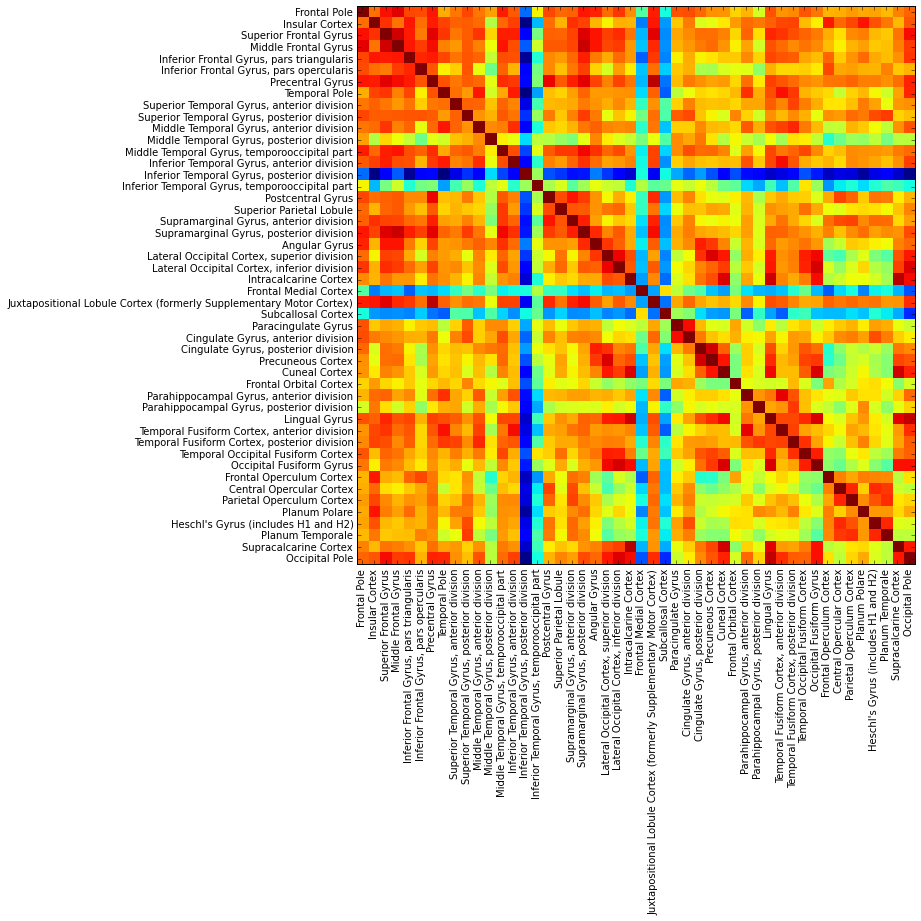

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(correlation, interpolation="nearest")
x_ticks = plt.xticks(range(len(labels) - 1), labels[1:], rotation=90)
y_ticks = plt.yticks(range(len(labels) - 1), labels[1:])

This is somewhat messy isn't it: everything is connected to everything.

What did we forget?



## Improving the connectivity matrix

**Exercise**: Improve this connectivity matrix

**Hint**: What in 'data.keys' can be used to improve the connectivity matrix? Look at the arguments of masker.fit_transform to find how to use it.

In [41]:
"""
Extracting brain signal from spheres
====================================

This example extract brain signals from spheres described by the coordinates
of their center in MNI space and a given radius in millimeters. In particular,
this example extracts signals from Default Mode Network regions and compute a
connectome from them.

"""

# Fetching dataset ############################################################
from nilearn import datasets
adhd_dataset = datasets.fetch_adhd(n_subjects=1)

# print basic information on the dataset
print('First subject functional nifti image (4D) is at: %s' %
      adhd_dataset.func[0])  # 4D data


# Extracting region signals ###################################################
from nilearn import input_data


# Coordinates of Default Mode Network
dmn_coords = [(0, -52, 18), (-46, -68, 32), (46, -68, 32), (0, 50, -5)]
labels = [
    'Posterior Cingulate Cortex',
    'Left Temporoparietal junction',
    'Right Temporoparietal junction',
    'Medial prefrontal cortex'
]

# Extracting signal from sphere around DMN seeds
masker = input_data.NiftiSpheresMasker(
    dmn_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2.5,
    memory='nilearn_cache', memory_level=1, verbose=2)

func_filename = adhd_dataset.func[0]
confound_filename = adhd_dataset.confounds[0]

time_series = masker.fit_transform(func_filename,
                             confounds=[confound_filename])

First subject functional nifti image (4D) is at: /Users/admin/nilearn_data/adhd/data/3902469/3902469_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiSpheresMasker.fit_transform] loading images: /Users/admin/nilearn_data/adhd/data/3902469/3902469_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiSpheresMasker.fit_transform] extracting region signals
[Memory]    0.0s, 0.0min: Loading _signals_from_spheres...
[NiftiSpheresMasker.fit_transform] cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[  8308.390625, ...,  12388.024414],
       ..., 
       [  8420.728516, ...,  12591.206055]]), standardize=True, detrend=True, confounds=['/Users/admin/nilearn_data/adhd/data/3902469/3902469_regressors.csv'], low_pass=0.1, t_r=2.5, high_pass=0.01)
____________________________________________________________clean - 0.0s, 0.0min


In [42]:
confound_filename

'/Users/admin/nilearn_data/adhd/data/3902469/3902469_regressors.csv'

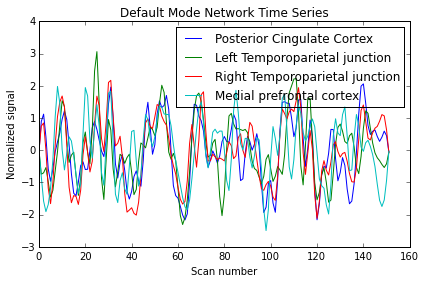

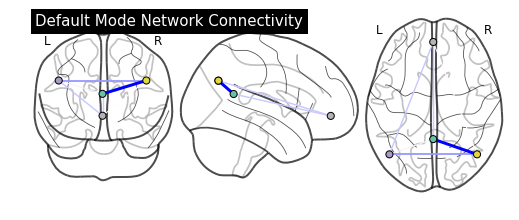

In [43]:
# Computing precision matrices ################################################
from sklearn.covariance import LedoitWolf
cve = LedoitWolf()
cve.fit(time_series)

# Displaying results ##########################################################
import matplotlib.pyplot as plt
from nilearn import plotting

# Display time series
for time_serie, label in zip(time_series.T, labels):
    plt.plot(time_serie, label=label)

plt.title('Default Mode Network Time Series')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.legend()
plt.tight_layout()

# Display connectome
title = "Default Mode Network Connectivity"
plotting.plot_connectome(cve.precision_, dmn_coords, title=title)
plt.show()

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image('/usr/share/data/harvard-oxford-atlases/HarvardOxford/HarvardOxford-cort-maxprob-thr25-2mm.nii.gz')
[NiftiLabelsMasker.fit_transform] loading images: /home/varoquau/nilearn_data/adhd/data/3902469/3902469_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiLabelsMasker.fit_transform] resampling images
[Memory]    0.0s, 0.0min: Loading resample_img...
________________________________________resample_img cache loaded - 1.8s, 0.0min
[NiftiLabelsMasker.fit_transform] extracting region signals
[Memory]    1.8s, 0.0min: Loading img_to_signals_labels...
_______________________________img_to_signals_labels cache loaded - 0.0s, 0.0min
[NiftiLabelsMasker.fit_transform] cleaning extracted signals
[Memory]    0.0s, 0.0min: Loading clean...
_______________________________________________clean cache loaded - 0.0s, 0.0min


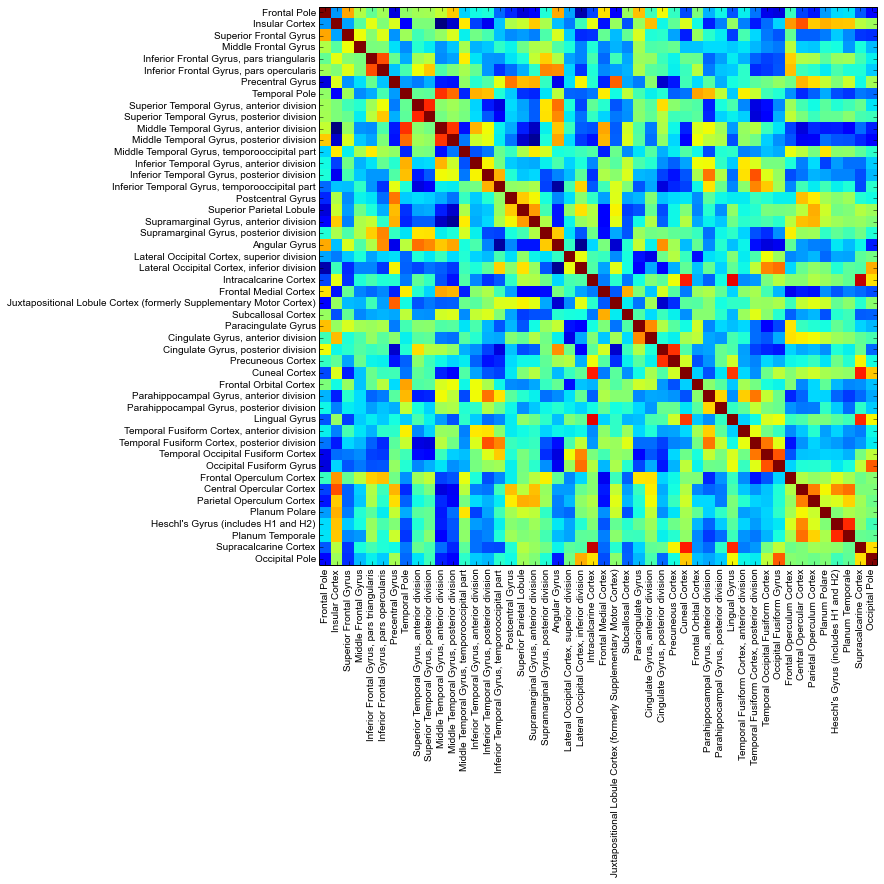

In [9]:
from nilearn import datasets
atlas_img, labels = datasets.load_harvard_oxford('cort-maxprob-thr25-2mm')

from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=True,
                           memory='/tmp/nilearn_course', verbose=5)

from matplotlib import pyplot as plt
data = datasets.fetch_adhd(n_subjects=1)

time_series = masker.fit_transform(data.func[0],
                                   confounds=data.confounds)

import numpy as np
correlation = np.corrcoef(time_series.T)
plt.figure(figsize=(10, 10))
plt.imshow(correlation, interpolation="nearest")
x_ticks = plt.xticks(range(len(labels) - 1), labels[1:], rotation=90)
y_ticks = plt.yticks(range(len(labels) - 1), labels[1:])


Better? Maybe, but one problem is that the atlas does not resolve functional structures: if we look at which regions the PCC correlates strongly with, we are expecting to find the various parts of the default mode network. However, there are no parietal regions, as the parietal lobe is not divided properly in the Harvard Oxford atlas.

Thus, it is of interest to use an atlas of function regions.

# Extracting signal on a probabilistic atlas

We can use the MSDL atlas (Varoquaux, IPMI 2011), which is a probabilistic atlas: it is a set of weighted maps that capture functional regions at rest.

/git/scikit-learn/sklearn/utils/__init__.py:94: DeprecationWarning: Function fetch_msdl_atlas is deprecated; it has been replace by fetch_atlas_msdl and will be removed in nilearn 0.1.5
  warnings.warn(msg, category=DeprecationWarning)


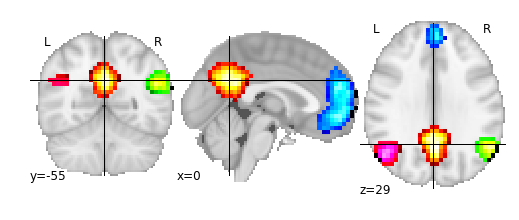

In [37]:
atlas = datasets.fetch_msdl_atlas()
atlas_img = atlas['maps']
labels = atlas['labels']

# Plot the regions defining the default-mode network
import nibabel
atlas_img = nibabel.load(atlas_img)
display = plotting.plot_stat_map(nibabel.Nifti1Image(atlas_img.get_data()[..., 4],
                                                     atlas_img.get_affine()),
                        colorbar=False)
display.add_overlay(nibabel.Nifti1Image(atlas_img.get_data()[..., 5],
                                                     atlas_img.get_affine()),
                    cmap=plotting.cm.black_blue, vmax=.5, vmin=0)
display.add_overlay(nibabel.Nifti1Image(atlas_img.get_data()[..., 6],
                                                     atlas_img.get_affine()),
                    cmap=plotting.cm.black_green, vmax=.5, vmin=0)
display.add_overlay(nibabel.Nifti1Image(atlas_img.get_data()[..., 3],
                                                     atlas_img.get_affine()),
                    cmap=plotting.cm.black_pink, vmax=.5, vmin=0)

To extract time-series on such regions, "softly" defined by continuous maps, we should use nilearn.input_data.NiftiMapsMasker.

**Excercise**: By analogy with the above, compute and display a correlation matrix on the MSDL atlas.

**Note**: On nilearn 1.0 beta, it is not possible to retrieve correct labels for the MSDL atlas. This has been fixed in later versions.

In [38]:
# Solution
%load adhd_msdl_connectivity.py

ValueError: 'adhd_msdl_connectivity.py' was not found in history, as a file, url, nor in the user namespace.

In [35]:
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()
atlas['labels']

['L Aud',
 'R Aud',
 'Striate',
 'L DMN',
 'Med DMN',
 'Front DMN',
 'R DMN',
 'Occ post',
 'Motor',
 'R DLPFC',
 'R Front pol',
 'R Par',
 'R Post Temp',
 'Basal',
 'L Par',
 'L DLPFC',
 'L Front pol',
 'L IPS',
 'R IPS',
 'L LOC',
 'Vis',
 'R LOC',
 'D ACC',
 'V ACC',
 'R A Ins',
 'L STS',
 'R STS',
 'L TPJ',
 'Broca',
 ' Sup Front S',
 ' R TPJ',
 '  R Pars Op',
 'Cereb',
 'Dors PCC',
 '  L Ins',
 '    Cing',
 '   R Ins',
 'L Ant IPS',
 'R Ant IPS']

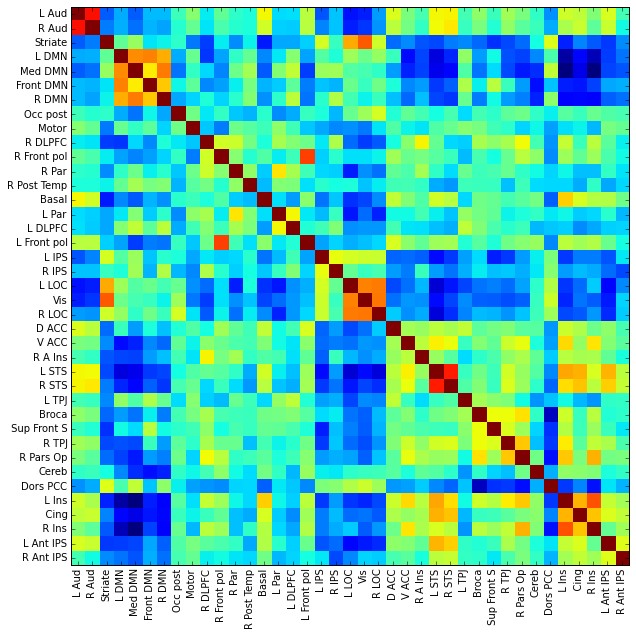

In [37]:
from nilearn import datasets
atlas = datasets.fetch_atlas_msdl()
atlas_img = atlas['maps']
import pandas
# labels = pandas.read_csv(atlas['labels'])['name']
labels = atlas['labels']

from nilearn.input_data import NiftiMapsMasker

masker = NiftiMapsMasker(maps_img=atlas_img, standardize=True,
                           memory='/tmp/nilearn_course', verbose=0)

from matplotlib import pyplot as plt
data = datasets.fetch_adhd(n_subjects=1)

time_series = masker.fit_transform(data.func[0],
                                   confounds=data.confounds)

import numpy as np
correlation = np.corrcoef(time_series.T)
plt.figure(figsize=(10, 10))
plt.imshow(correlation, interpolation="nearest")
x_ticks = plt.xticks(range(len(labels)), labels, rotation=90)
y_ticks = plt.yticks(range(len(labels)), labels)


**Excercise** Compute the corresponding correlation matrix for a few other subjects in the ADHD dataset.

# Inverse covariance estimation

We can start by using the covariance estimators in scikit-learn

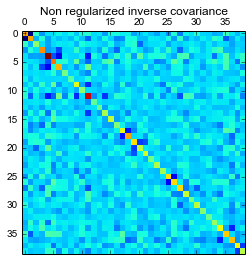

In [14]:
from sklearn import covariance
estimator = covariance.EmpiricalCovariance(store_precision=True)
estimator.fit(time_series)
plt.matshow(estimator.precision_)
plt.title('Non regularized inverse covariance')

**Excercise**: Now use covariance.GraphLassoCV to estimate a sparse inverse covariance.

Finally, give that we have multiple subjects, we can use the group-sparse model, to have better sparse recovery. For this we use the corresponding model in nilearn.covariance. It requires several time-series.

[NiftiMapsMasker.fit_transform] loading regions from /home/varoquau/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
[NiftiMapsMasker.fit_transform] loading images from /home/varoquau/nilearn_data/adhd/data/3902469/3902469_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiMapsMasker.fit_transform] resampling images to fit maps
[Memory]    0.0s, 0.0min: Loading resample_img...
________________________________________resample_img cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] extracting region signals
[Memory]    0.2s, 0.0min: Loading img_to_signals_maps...
_________________________________img_to_signals_maps cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] cleaning extracted signals
[Memory]    0.0s, 0.0min: Loading clean...
_______________________________________________clean cache loaded - 0.0s, 0.0min
[NiftiMapsMasker.fit_transform] loading regions from /home/varoquau/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
[NiftiMapsMasker.fit_transform] loading images from /home

/home/varoquau/dev/scikit-learn/sklearn/cross_validation.py:1544: DeprecationWarning: check_cv will return indices instead of boolean masks from 0.17
  'masks from 0.17', DeprecationWarning)
/home/varoquau/dev/scikit-learn/sklearn/cross_validation.py:66: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  stacklevel=1)
/home/varoquau/dev/scikit-learn/sklearn/cross_validation.py:1544: DeprecationWarning: check_cv will return indices instead of boolean masks from 0.17
  'masks from 0.17', DeprecationWarning)
/home/varoquau/dev/scikit-learn/sklearn/cross_validation.py:66: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  stacklevel=1)
/home/varoquau/dev/scikit-learn/sklearn/cross_validation.py:1544: DeprecationWarning: check_cv will return indices instead of boolean masks from 0.17
  'masks from 0.17', DeprecationWarning)
/home/varoquau/dev/scikit-learn/sklearn/cross_validation.py:66: Depre


[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 2: 8.830e-08
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 2: 4.187e-07
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 1
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 6
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  1 out of 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 8
[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 7: 6.400e-03


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.5s



[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 7
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 2
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 5
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  2 out of 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 9
[GroupSparseCovarianceCV.fit] tolerance reached at 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    5.0s



[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 8
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 2
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 2
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 5: 9.363e-03
[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 5: 9.148e-03
[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 6: 6.996e-03
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  3 out of 4
[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 11: 9.496e-03
[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 4: 5.888e-03
[GroupSparseCovarianceCV.fit]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    4.9s



[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 12
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 2
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 6: 7.184e-03
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  4 out of 4
[GroupSparseCovarianceCV.fit] Final optimization
[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 16: 8.182e-04


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.4s finished


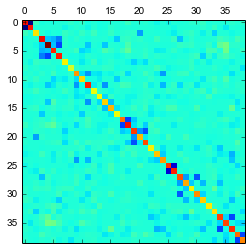

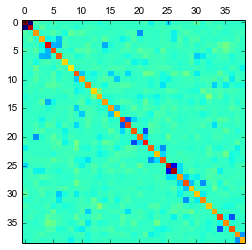

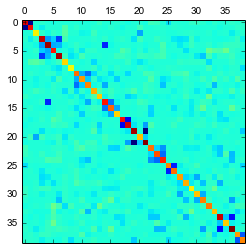

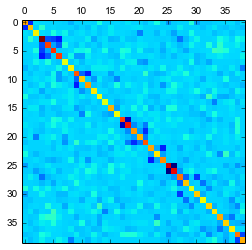

In [16]:
# Get the ADHD data for multiple subjects
data = datasets.fetch_adhd(n_subjects=4)

# And apply the masker to the functional data of each subject
time_series = list()
for subject_data, subject_confounds in zip(data.func, data.confounds):
     time_series.append(masker.fit_transform(subject_data, confounds=subject_confounds))

from nilearn.group_sparse_covariance import GroupSparseCovarianceCV
estimator = GroupSparseCovarianceCV()
estimator.fit(time_series)
for precision in estimator.precisions_.T:
    plt.matshow(precision)

**Signals extractions from a probabilistic brain atlas**
==

First subject resting-state nifti image (4D) is located at: /Users/admin/nilearn_data/adhd/data/3902469/3902469_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiMapsMasker.fit_transform] loading regions from /Users/admin/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
[NiftiMapsMasker.fit_transform] loading images from /Users/admin/nilearn_data/adhd/data/3902469/3902469_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiMapsMasker.fit_transform] resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x10eb06f90>, target_shape=(61, 73, 61), target_affine=array([[  -3.,   -0.,   -0.,   90.],
       [  -0.,    3.,   -0., -126.],
       [   0.,    0.,    3.,  -72.],
       [   0.,    0.,    0.,    1.]]), interpolation='continuous')
_____________________________________________________resample_img - 8.6s, 0.1min
[NiftiMapsMasker.fit_transform] extracting region 

/git/nilearn/nilearn/_utils/cache_mixin.py:211: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


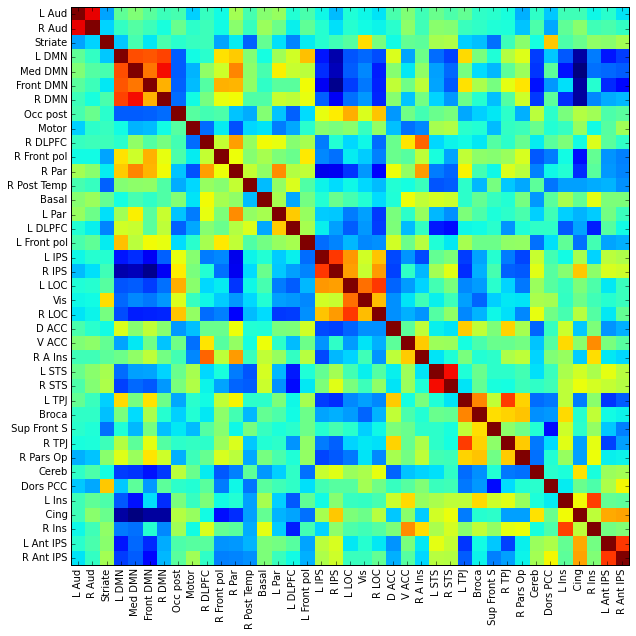

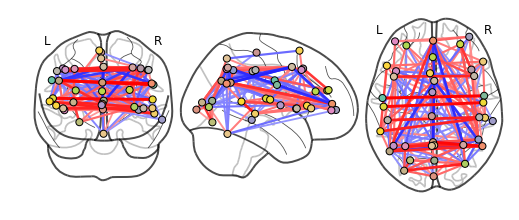

In [14]:
"""
Extracting signals of a probabilistic atlas of rest functional regions
========================================================================

This example extracts the signal on regions defined via a probabilistic
atlas, to construct a functional connectome.

We use the `MSDL atlas
<https://team.inria.fr/parietal/research/spatial_patterns/spatial-patterns-in-resting-state/>`_
of functional regions in rest.

The key to extract signals is to use the
:class:`nilearn.input_data.NiftiMapsMasker` that can transform nifti
objects to time series using a probabilistic atlas.

As the MSDL atlas comes with (x, y, z) MNI coordinates for the different
regions, we can visualize the matrix as a graph of interaction in a
brain. To avoid having too dense a graph, we represent only the 20% edges
with the highest values.

"""

from nilearn import datasets
atlas = datasets.fetch_msdl_atlas()
atlas_filename = atlas['maps']

# Load the labels
import numpy as np
csv_filename = atlas['labels']

# The recfromcsv function can load a csv file
labels = np.recfromcsv(csv_filename)
names = labels['name']

from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=5)

data = datasets.fetch_adhd(n_subjects=1)

# print basic dataset information
print('First subject resting-state nifti image (4D) is located at: %s' %
      data.func[0])

time_series = masker.fit_transform(data.func[0],
                                   confounds=data.confounds)

correlation_matrix = np.corrcoef(time_series.T)

# Display the correlation matrix
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(correlation_matrix, interpolation="nearest")
# And display the labels
x_ticks = plt.xticks(range(len(names)), names, rotation=90)
y_ticks = plt.yticks(range(len(names)), names)

# And now display the corresponding graph
from nilearn import plotting
coords = np.vstack((labels['x'], labels['y'], labels['z'])).T

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix, coords,
                         edge_threshold="80%")

plt.show()




**Confounds in connectome computation**
==

-- Fetching datasets ...
First subject functional nifti image (4D) is at: /Users/admin/nilearn_data/adhd/data/3902469/3902469_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiMapsMasker.fit] loading regions from /Users/admin/nilearn_data/msdl_atlas/MSDL_rois/msdl_rois.nii
Processing file /Users/admin/nilearn_data/adhd/data/3902469/3902469_rest_tshift_RPI_voreg_mni.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.image.image.high_variance_confounds...
high_variance_confounds('/Users/admin/nilearn_data/adhd/data/3902469/3902469_rest_tshift_RPI_voreg_mni.nii.gz')
__________________________________________high_variance_confounds - 3.1s, 0.1min
[NiftiMapsMasker.transform] loading images from /Users/admin/nilearn_data/adhd/data/3902469/3902469_rest_tshift_RPI_voreg_mni.nii.gz
[NiftiMapsMasker.transform] resampling images to fit maps
________________________________________________________________________________
[Memory] Calling nilearn.i

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.9s finished



[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  1 out of 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s finished



[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  2 out of 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.0s finished



[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  3 out of 4
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 3
[GroupSparseCovarianceCV.fit] Log-likelihood on test set is decreasing. Stopping at iteration 0

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.9s finished



[GroupSparseCovarianceCV.fit] [GroupSparseCovarianceCV] Done refinement  4 out of 4
[GroupSparseCovarianceCV.fit] Final optimization
[GroupSparseCovarianceCV.fit] tolerance reached at iteration number 10: 9.992e-04

....[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
.......


-- Computing graph-lasso precision matrices ...
[GraphLassoCV] Done refinement  1 out of 4:   0s

.[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
....[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
......


[GraphLassoCV] Done refinement  2 out of 4:   0s

..[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
....[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
........


[GraphLassoCV] Done refinement  3 out of 4:   0s

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
....[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.1s
......


[GraphLassoCV] Done refinement  4 out of 4:   1s
[graph_lasso] Iteration   0, cost  1.74e+02, dual gap 1.123e+00
[graph_lasso] Iteration   1, cost  1.74e+02, dual gap 1.332e-03
[graph_lasso] Iteration   2, cost  1.74e+02, dual gap 2.418e-04
[graph_lasso] Iteration   3, cost  1.74e+02, dual gap 4.035e-05


..[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


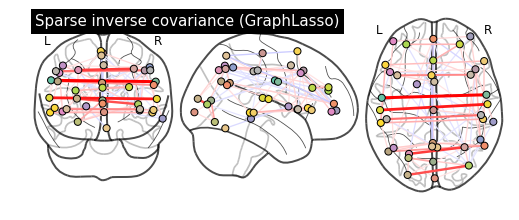

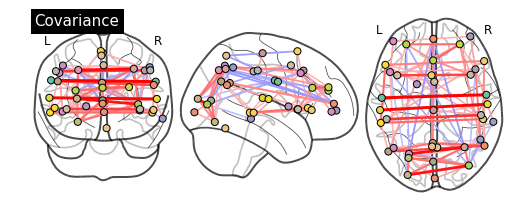

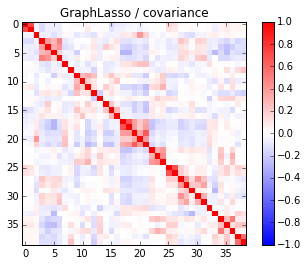

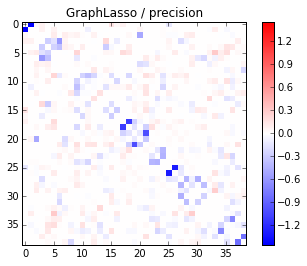

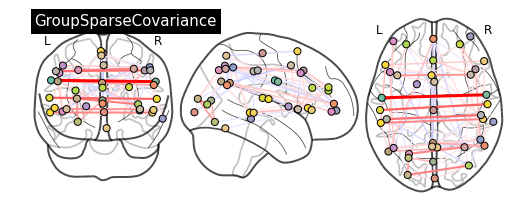

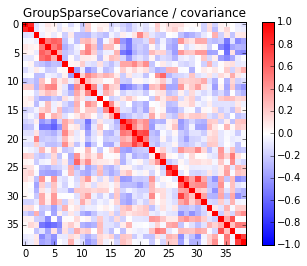

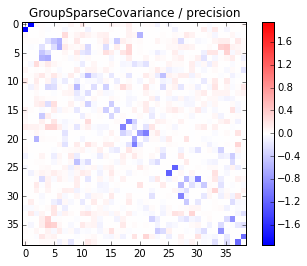

In [ ]:
"""
Group Sparse inverse covariance for multi-subject connectome
=============================================================

This example shows how to estimate a connectome on a groupe of subjects
using the group sparse inverse covariance estimate.

"""
import matplotlib.pyplot as plt
import numpy as np

from nilearn import plotting


n_subjects = 4  # subjects to consider for group-sparse covariance (max: 40)


def plot_matrices(cov, prec, title):
    """Plot covariance and precision matrices, for a given processing. """

    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    # Display covariance matrix
    plt.figure()
    plt.imshow(cov, interpolation="nearest",
               vmin=-1, vmax=1, cmap=plotting.cm.bwr)
    plt.colorbar()
    plt.title("%s / covariance" % title)

    # Display precision matrix
    plt.figure()
    plt.imshow(prec, interpolation="nearest",
               vmin=-span, vmax=span,
               cmap=plotting.cm.bwr)
    plt.colorbar()
    plt.title("%s / precision" % title)


# Fetching datasets ###########################################################
print("-- Fetching datasets ...")
from nilearn import datasets
msdl_atlas_dataset = datasets.fetch_msdl_atlas()
adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)

# print basic information on the dataset
print('First subject functional nifti image (4D) is at: %s' %
      adhd_dataset.func[0])  # 4D data


# Extracting region signals ###################################################
from nilearn import image
from nilearn import input_data

from sklearn.externals.joblib import Memory
mem = Memory('nilearn_cache')

masker = input_data.NiftiMapsMasker(
    msdl_atlas_dataset.maps, resampling_target="maps", detrend=True,
    low_pass=None, high_pass=0.01, t_r=2.5, standardize=True,
    memory=mem, memory_level=1, verbose=2)
masker.fit()

subject_time_series = []
func_filenames = adhd_dataset.func
confound_filenames = adhd_dataset.confounds
for func_filename, confound_filename in zip(func_filenames,
                                            confound_filenames):
    print("Processing file %s" % func_filename)

    # Computing some confounds
    hv_confounds = mem.cache(image.high_variance_confounds)(
        func_filename)

    region_ts = masker.transform(func_filename,
                                 confounds=[hv_confounds, confound_filename])
    subject_time_series.append(region_ts)

# Computing group-sparse precision matrices ###################################
print("-- Computing group-sparse precision matrices ...")
from nilearn.group_sparse_covariance import GroupSparseCovarianceCV
gsc = GroupSparseCovarianceCV(verbose=2)
gsc.fit(subject_time_series)

print("-- Computing graph-lasso precision matrices ...")
from sklearn import covariance
gl = covariance.GraphLassoCV(verbose=2)
gl.fit(np.concatenate(subject_time_series))

# Displaying results ##########################################################
atlas_imgs = image.iter_img(msdl_atlas_dataset.maps)
atlas_region_coords = [plotting.find_xyz_cut_coords(img) for img in atlas_imgs]

title = "GraphLasso"
plotting.plot_connectome(-gl.precision_, atlas_region_coords,
                         edge_threshold='90%',
                         title="Sparse inverse covariance (GraphLasso)")
plotting.plot_connectome(gl.covariance_,
                         atlas_region_coords, edge_threshold='90%',
                         title="Covariance")
plot_matrices(gl.covariance_, gl.precision_, title)

title = "GroupSparseCovariance"
plotting.plot_connectome(-gsc.precisions_[..., 0],
                         atlas_region_coords, edge_threshold='90%',
                         title=title)
plot_matrices(gsc.covariances_[..., 0],
              gsc.precisions_[..., 0], title)

plt.show()


**Basic ICA example**
==

In [2]:
"""
Independent component analysis of resting-state fMRI
=====================================================

An example applying ICA to resting-state data.
"""

### Load nyu_rest dataset #####################################################
from nilearn import datasets
# Here we use only 3 subjects to get faster-running code. For better
# results, simply increase this number
# XXX: must get the code to run for more than 1 subject
nyu_dataset = datasets.fetch_nyu_rest(n_subjects=1)
func_filename = nyu_dataset.func[0]

# print basic information on the dataset
print('First subject anatomical nifti image (3D) is at: %s' %
      nyu_dataset.anat_anon[0])
print('First subject functional nifti image (4D) is at: %s' %
      nyu_dataset.func[0])  # 4D data

First subject anatomical nifti image (3D) is at: /Users/admin/nilearn_data/nyu_rest/session1/sub05676/anat/mprage_anonymized.nii.gz
First subject functional nifti image (4D) is at: /Users/admin/nilearn_data/nyu_rest/session1/sub05676/func/lfo.nii.gz


In [3]:
### Preprocess ################################################################
from nilearn.input_data import NiftiMasker

# This is resting-state data: the background has not been removed yet,
# thus we need to use mask_strategy='epi' to compute the mask from the
# EPI images
masker = NiftiMasker(smoothing_fwhm=8, memory='nilearn_cache', memory_level=1,
                     mask_strategy='epi', standardize=False)
data_masked = masker.fit_transform(func_filename)

# Concatenate all the subjects
# fmri_data = np.concatenate(data_masked, axis=1)
fmri_data = data_masked


### Apply ICA #################################################################

from sklearn.decomposition import FastICA
n_components = 20
ica = FastICA(n_components=n_components, random_state=42)
components_masked = ica.fit_transform(data_masked.T).T

In [6]:
components_masked.T

array([[  7.81105471e-04,  -2.70548384e-03,  -2.42480855e-03, ...,
         -4.45317207e-04,  -1.14233933e-02,  -6.58699227e-04],
       [  3.86360513e-04,  -4.46518378e-04,  -1.62004588e-03, ...,
         -5.86170106e-04,  -1.08016879e-02,  -3.79429686e-03],
       [ -2.99787435e-05,   1.21135020e-03,  -1.19089739e-03, ...,
         -1.70812133e-04,  -7.20805558e-03,  -5.69892783e-03],
       ..., 
       [ -1.67474972e-04,  -2.23837953e-03,   4.46127473e-03, ...,
          7.62463728e-03,   3.22952248e-03,   9.59135667e-04],
       [ -1.12352358e-03,  -1.97258251e-03,   4.14803148e-03, ...,
          7.84564124e-03,   5.02135720e-03,   5.18023398e-04],
       [  8.19004150e-04,   3.82661926e-04,   2.56554388e-03, ...,
          3.44060066e-03,   4.04966984e-03,  -6.38144745e-04]])

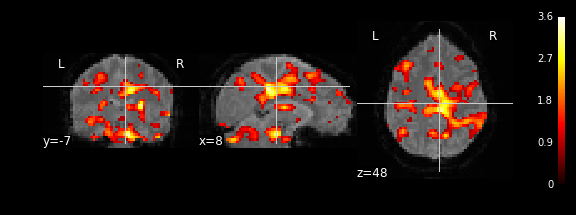

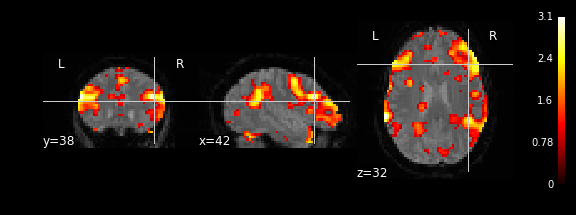

In [7]:
# Normalize estimated components, for thresholding to make sense
components_masked -= components_masked.mean(axis=0)
components_masked /= components_masked.std(axis=0)
# Threshold
components_masked[components_masked < .8] = 0

# Now invert the masking operation, going back to a full 3D
# representation
component_img = masker.inverse_transform(components_masked)

### Visualize the results #####################################################
# Show some interesting components
import matplotlib.pyplot as plt
from nilearn import image
from nilearn.plotting import plot_stat_map

# Use the mean as a background
mean_img = image.mean_img(func_filename)

plot_stat_map(image.index_img(component_img, 5), mean_img)

plot_stat_map(image.index_img(component_img, 12), mean_img)

plt.show()

**CanonicalICA example**
==

In [ ]:
"""
Group analysis of resting-state fMRI with ICA: CanICA
=====================================================

An example applying CanICA to resting-state data. This example applies it
to 40 subjects of the ADHD200 datasets.

CanICA is an ICA method for group-level analysis of fMRI data. Compared
to other strategies, it brings a well-controlled group model, as well as a
thresholding algorithm controlling for specificity and sensitivity with
an explicit model of the signal. The reference papers are:

    * G. Varoquaux et al. "A group model for stable multi-subject ICA on
      fMRI datasets", NeuroImage Vol 51 (2010), p. 288-299

    * G. Varoquaux et al. "ICA-based sparse features recovery from fMRI
      datasets", IEEE ISBI 2010, p. 1177

Pre-prints for both papers are available on hal
(http://hal.archives-ouvertes.fr)
"""

### Load ADHD rest dataset ####################################################
from nilearn import datasets

adhd_dataset = datasets.fetch_adhd()
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' %
      adhd_dataset.func[0])  # 4D data

### Apply CanICA ##############################################################
from nilearn.decomposition.canica import CanICA

n_components = 20
canica = CanICA(n_components=n_components, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=5,
                threshold=3., verbose=10, random_state=0)
canica.fit(func_filenames)

# Retrieve the independent components in brain space
components_img = canica.masker_.inverse_transform(canica.components_)
# components_img is a Nifti Image object, and can be saved to a file with
# the following line:
components_img.to_filename('canica_resting_state.nii.gz')

### Visualize the results #####################################################
# Show some interesting components
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map
from nilearn.image import iter_img

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i, cut_coords=1,
                  colorbar=False)

plt.show()


[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   5 jobs       | elapsed:    7.7s


**Regional clustering based on resting-state data**
==

In [ ]:
"""
Ward clustering to learn a brain parcellation from rest fMRI
====================================================================

We use spatially-constrained Ward-clustering to create a set of
parcels. These parcels are particularly interesting for creating a
'compressed' representation of the data, replacing the data in the fMRI
images by mean on the parcellation.

This parcellation may be useful in a supervised learning, see for
instance: `A supervised clustering approach for fMRI-based inference of
brain states <https://hal.inria.fr/inria-00589201>`_, Michel et al,
Pattern Recognition 2011.

"""

### Load nyu_rest dataset #####################################################

import numpy as np
from nilearn import datasets
from nilearn import input_data
from nilearn.plotting.img_plotting import plot_roi, plot_epi
nyu_dataset = datasets.fetch_nyu_rest(n_subjects=1)

# print basic information on the dataset
print('First subject anatomical nifti image (3D) is at: %s' %
      nyu_dataset.anat_anon[0])
print('First subject functional nifti image (4D) is at: %s' %
      nyu_dataset.func[0])  # 4D data

# This is resting-state data: the background has not been removed yet,
# thus we need to use mask_strategy='epi' to compute the mask from the
# EPI images
nifti_masker = input_data.NiftiMasker(memory='nilearn_cache',
                                      mask_strategy='epi', memory_level=1,
                                      standardize=False)
func_filename = nyu_dataset.func[0]
fmri_masked = nifti_masker.fit_transform(func_filename)
mask = nifti_masker.mask_img_.get_data().astype(np.bool)

### Ward ######################################################################

# Compute connectivity matrix: which voxel is connected to which
from sklearn.feature_extraction import image
shape = mask.shape
connectivity = image.grid_to_graph(n_x=shape[0], n_y=shape[1],
                                   n_z=shape[2], mask=mask)

# Computing the ward for the first time, this is long...
from sklearn.cluster import FeatureAgglomeration
# If you have scikit-learn older than 0.14, you need to import
# WardAgglomeration instead of FeatureAgglomeration
import time
start = time.time()
ward = FeatureAgglomeration(n_clusters=1000, connectivity=connectivity,
                            linkage='ward', memory='nilearn_cache')
ward.fit(fmri_masked)
print("Ward agglomeration 1000 clusters: %.2fs" % (time.time() - start))

# Compute the ward with more clusters, should be faster as we are using
# the caching mechanism
start = time.time()
ward = FeatureAgglomeration(n_clusters=2000, connectivity=connectivity,
                            linkage='ward', memory='nilearn_cache')
ward.fit(fmri_masked)
print("Ward agglomeration 2000 clusters: %.2fs" % (time.time() - start))

### Show result ###############################################################

# Unmask data
# Avoid 0 label
labels = ward.labels_ + 1
labels_img = nifti_masker.inverse_transform(labels)

from nilearn.image import mean_img
import matplotlib.pyplot as plt
mean_func_img = mean_img(func_filename)

# common cut coordinates for all plots

first_plot = plot_roi(labels_img, mean_func_img, title="Ward parcellation",
                      display_mode='xz')
# labels_img is a Nifti1Image object, it can be saved to file with the
# following code:
labels_img.to_filename('parcellation.nii')


# Display the original data
plot_epi(nifti_masker.inverse_transform(fmri_masked[0]),
         cut_coords=first_plot.cut_coords,
         title='Original (%i voxels)' % fmri_masked.shape[1],
         display_mode='xz')

# A reduced data can be create by taking the parcel-level average:
# Note that, as many objects in the scikit-learn, the ward object exposes
# a transform method that modifies input features. Here it reduces their
# dimension
fmri_reduced = ward.transform(fmri_masked)

# Display the corresponding data compressed using the parcellation
fmri_compressed = ward.inverse_transform(fmri_reduced)
compressed_img = nifti_masker.inverse_transform(fmri_compressed[0])

plot_epi(compressed_img, cut_coords=first_plot.cut_coords,
         title='Compressed representation (2000 parcels)',
         display_mode='xz')

plt.show()
